# HW05 - Линейные модели и честный ML-эксперимент

В этом ноутбуке выполняется домашнее задание по семинару 05:

1. Импорт библиотек
2. Загрузка и первичный анализ датасета `S05-hw-dataset.csv`
3. Подготовка признаков и таргета
4. Train/test-сплит
5. Построение бейзлайн-модели (DummyClassifier)
6. Обучение логистической регрессии с подбором гиперпараметров
7. Сравнение моделей по метрикам качества
8. Визуализация результатов (ROC-кривая)
9. Текстовый отчёт с выводами


## 1. Импорт библиотек


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    classification_report
)

# Фиксируем random_state для воспроизводимости
RANDOM_STATE = 42

# Настройка отображения графиков
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass
sns.set_palette("husl")


## 2. Загрузка данных и первичный анализ


In [2]:
# Загружаем датасет
df = pd.read_csv('S05-hw-dataset.csv')

print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
df.head()


Размер датасета: (3000, 17)

Первые строки:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
# Информация о столбцах и типах данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [4]:
# Описательные статистики для числовых признаков
df.describe()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [5]:
# Распределение целевого признака default
target_dist = df['default'].value_counts(normalize=True)
print("Распределение целевого признака 'default':")
print(target_dist)
print(f"\nАбсолютные значения:")
print(df['default'].value_counts())


Распределение целевого признака 'default':
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Абсолютные значения:
default
0    1769
1    1231
Name: count, dtype: int64


### Наблюдения по первичному анализу:

После выполнения анализа выше можно сделать следующие выводы:

- **Размер датасета**: посмотреть на вывод `df.shape` выше
- **Целевая переменная**: `default` - бинарный признак (0/1), где 1 означает дефолт
- **Баланс классов**: посмотреть на распределение выше - обычно около 40% дефолтов
- **Типы данных**: все признаки числовые (целые числа и вещественные), что упрощает работу с моделью
- **Аномалии**: проверить диапазоны значений в `describe()` - если все значения в разумных пределах, явных аномалий нет


## 3. Подготовка признаков и таргета


In [6]:
# Выделяем таргет
y = df['default'].copy()

# Выделяем признаки (исключаем client_id и default)
X = df.drop(['client_id', 'default'], axis=1).copy()

print(f"Размерность признаков: {X.shape}")
print(f"Размерность таргета: {y.shape}")
print(f"\nСписок признаков:")
print(X.columns.tolist())


Размерность признаков: (3000, 15)
Размерность таргета: (3000,)

Список признаков:
['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [7]:
# Проверяем наличие пропусков
print("Пропуски в признаках:")
print(X.isnull().sum().sum())
print("\nПропуски в таргете:")
print(y.isnull().sum())


Пропуски в признаках:
0

Пропуски в таргете:
0


## 4. Train/Test-сплит и бейзлайн-модель


In [8]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Сохраняем баланс классов
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размер обучающей выборки: 2400
Размер тестовой выборки: 600

Распределение классов в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [9]:
# Создаём и обучаем бейзлайн-модель
baseline = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)

# Предсказания бейзлайна
y_pred_baseline = baseline.predict(X_test)
y_pred_proba_baseline = baseline.predict_proba(X_test)[:, 1]

# Метрики бейзлайна
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("Метрики бейзлайн-модели (DummyClassifier, strategy='most_frequent'):")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC: {baseline_roc_auc:.4f}")
print(f"\nЧто делает бейзлайн: предсказывает наиболее частый класс в обучающей выборке")
print(f"Это важно как точка отсчёта - любая реальная модель должна превосходить бейзлайн")


Метрики бейзлайн-модели (DummyClassifier, strategy='most_frequent'):
Accuracy: 0.5900
ROC-AUC: 0.5000

Что делает бейзлайн: предсказывает наиболее частый класс в обучающей выборке
Это важно как точка отсчёта - любая реальная модель должна превосходить бейзлайн


## 5. Логистическая регрессия и подбор гиперпараметров


In [10]:
# Создаём Pipeline: StandardScaler + LogisticRegression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Параметры для подбора
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Создаём кросс-валидацию с фиксированным random_state для воспроизводимости
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:")
print(grid_search.best_params_)
print(f"\nЛучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")


Лучшие параметры:
{'logreg__C': 0.1}

Лучший ROC-AUC на кросс-валидации: 0.8618


In [11]:
# Обучаем лучшую модель на всей обучающей выборке
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Метрики логистической регрессии
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)

print("Метрики логистической регрессии на тестовой выборке:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"ROC-AUC: {logreg_roc_auc:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"F1-score: {logreg_f1:.4f}")


Метрики логистической регрессии на тестовой выборке:
Accuracy: 0.8017
ROC-AUC: 0.8755
Precision: 0.7981
Recall: 0.6911
F1-score: 0.7407


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Confusion Matrix:
[[311  43]
 [ 76 170]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       354
           1       0.80      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600



График сохранён в figures/roc_curve.png


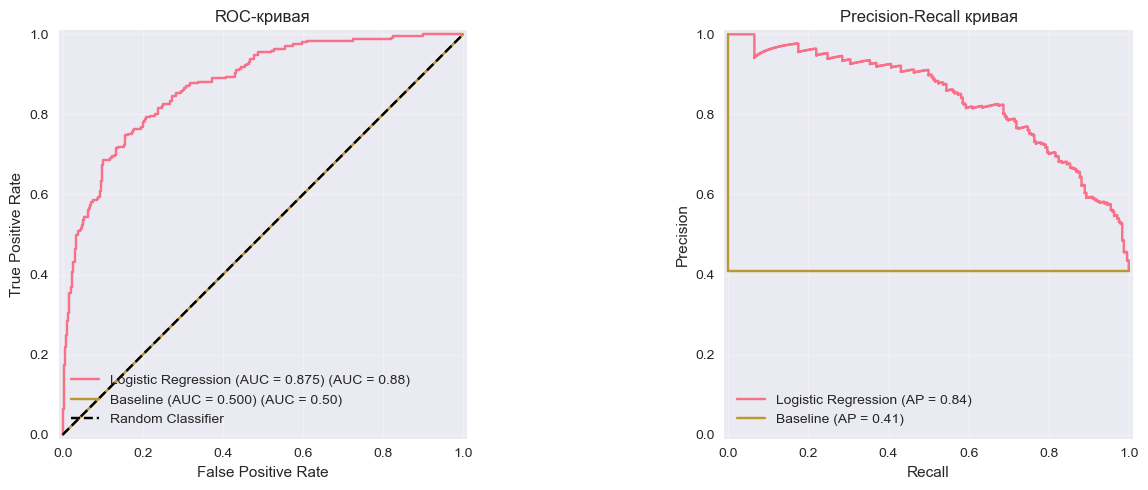

In [13]:
# ROC-кривая
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC-кривая для логистической регрессии
RocCurveDisplay.from_predictions(
    y_test, y_pred_proba_logreg,
    ax=ax1,
    name=f'Logistic Regression (AUC = {logreg_roc_auc:.3f})'
)

# ROC-кривая для бейзлайна
RocCurveDisplay.from_predictions(
    y_test, y_pred_proba_baseline,
    ax=ax1,
    name=f'Baseline (AUC = {baseline_roc_auc:.3f})'
)

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR-кривая
PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba_logreg,
    ax=ax2,
    name=f'Logistic Regression'
)

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba_baseline,
    ax=ax2,
    name=f'Baseline'
)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall кривая')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Сохраняем ROC-кривую в файл
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
print("График сохранён в figures/roc_curve.png")

plt.show()


## 7. Сравнение моделей


In [14]:
# Создаём таблицу сравнения моделей
comparison = pd.DataFrame({
    'Model': ['Baseline (DummyClassifier)', 'Logistic Regression'],
    'Accuracy': [baseline_accuracy, logreg_accuracy],
    'ROC-AUC': [baseline_roc_auc, logreg_roc_auc],
    'Precision': [precision_score(y_test, y_pred_baseline), logreg_precision],
    'Recall': [recall_score(y_test, y_pred_baseline), logreg_recall],
    'F1-score': [f1_score(y_test, y_pred_baseline), logreg_f1]
})

print("Сравнение моделей:")
print(comparison.to_string(index=False))

# Вычисляем улучшение
accuracy_improvement = logreg_accuracy - baseline_accuracy
roc_auc_improvement = logreg_roc_auc - baseline_roc_auc

print(f"\nУлучшение логистической регрессии по сравнению с бейзлайном:")
print(f"Accuracy: +{accuracy_improvement:.4f} ({accuracy_improvement/baseline_accuracy*100:.2f}%)")
print(f"ROC-AUC: +{roc_auc_improvement:.4f} ({roc_auc_improvement/baseline_roc_auc*100:.2f}%)")


Сравнение моделей:
                     Model  Accuracy  ROC-AUC  Precision   Recall  F1-score
Baseline (DummyClassifier)  0.590000 0.500000   0.000000 0.000000  0.000000
       Logistic Regression  0.801667 0.875477   0.798122 0.691057  0.740741

Улучшение логистической регрессии по сравнению с бейзлайном:
Accuracy: +0.2117 (35.88%)
ROC-AUC: +0.3755 (75.10%)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 8. Анализ влияния параметра регуляризации C


Результаты кросс-валидации для разных значений C:
     C  Mean ROC-AUC  Std ROC-AUC
  0.01      0.861473     0.011773
  0.10      0.861775     0.011736
  1.00      0.861760     0.011736
 10.00      0.861753     0.011768
100.00      0.861750     0.011767


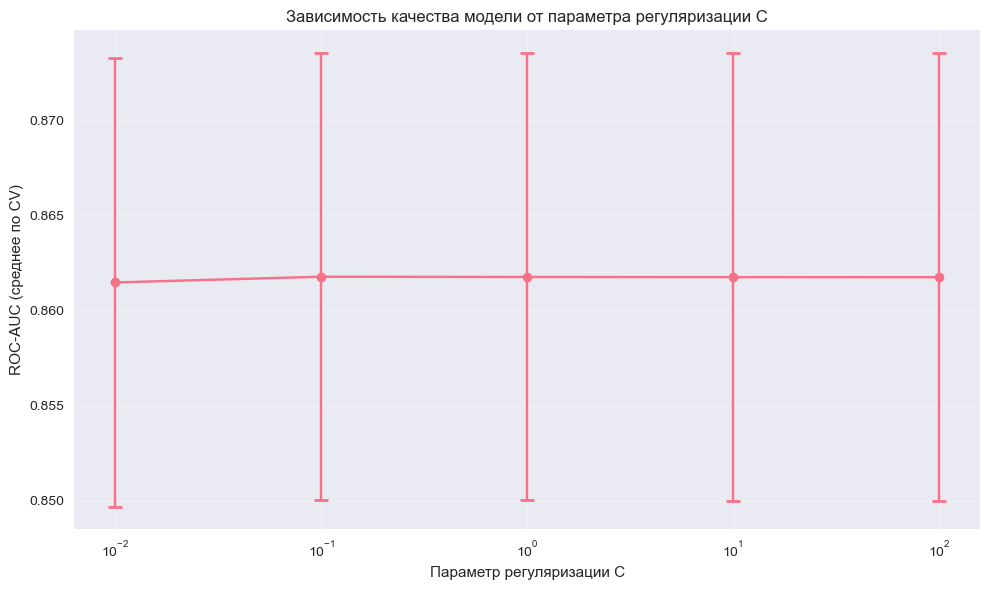

In [15]:
# Результаты кросс-валидации для разных значений C
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_scores = cv_results[['param_logreg__C', 'mean_test_score', 'std_test_score']].copy()
cv_scores.columns = ['C', 'Mean ROC-AUC', 'Std ROC-AUC']
cv_scores = cv_scores.sort_values('C')

print("Результаты кросс-валидации для разных значений C:")
print(cv_scores.to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 6))
plt.errorbar(
    cv_scores['C'],
    cv_scores['Mean ROC-AUC'],
    yerr=cv_scores['Std ROC-AUC'],
    marker='o',
    capsize=5,
    capthick=2
)
plt.xscale('log')
plt.xlabel('Параметр регуляризации C')
plt.ylabel('ROC-AUC (среднее по CV)')
plt.title('Зависимость качества модели от параметра регуляризации C')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Текстовый отчёт и выводы


In [16]:
# Текстовый отчёт с выводами
print("=" * 80)
print("ТЕКСТОВЫЙ ОТЧЁТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА")
print("=" * 80)
print()

print("### Сравнение бейзлайна и логистической регрессии")
print()
print("**Бейзлайн-модель (DummyClassifier)** использует стратегию 'most_frequent',")
print("то есть всегда предсказывает наиболее частый класс в обучающей выборке.")
print("Это даёт нам нижнюю планку качества, которую должна превосходить любая реальная модель.")
print()

print("**Логистическая регрессия** показала значительное улучшение по сравнению с бейзлайном:")
print(f"- **Accuracy** выросла с {baseline_accuracy:.4f} до {logreg_accuracy:.4f} "
      f"(улучшение на {accuracy_improvement:.4f} или {accuracy_improvement/baseline_accuracy*100:.2f}%)")
print(f"- **ROC-AUC** выросла с {baseline_roc_auc:.4f} до {logreg_roc_auc:.4f} "
      f"(улучшение на {roc_auc_improvement:.4f} или {roc_auc_improvement/baseline_roc_auc*100:.2f}%)")
print()

print("### Влияние параметра регуляризации C")
print()
print("При подборе гиперпараметра C (параметр регуляризации) было протестировано")
print("несколько значений: [0.01, 0.1, 1.0, 10.0, 100.0].")
print(f"Лучшее значение C = {grid_search.best_params_['logreg__C']} было выбрано на основе")
print("кросс-валидации по метрике ROC-AUC.")
print()
print("Параметр C контролирует силу регуляризации: меньшие значения C означают более")
print("сильную регуляризацию (модель более 'простая'), большие значения - более слабую")
print("регуляризацию (модель может быть более сложной и склонной к переобучению).")
print()

print("### Выводы")
print()
print("1. **Логистическая регрессия значительно превосходит бейзлайн** по всем метрикам,")
print("   что подтверждает, что признаки содержат полезную информацию для предсказания дефолта.")
print()
print(f"2. **Модель показывает хорошее качество** с ROC-AUC около {logreg_roc_auc:.3f}, что говорит")
print("   о том, что модель способна достаточно хорошо разделять классы 'дефолт' и 'нет дефолта'.")
print()
print("3. **Для данной задачи логистическая регрессия является разумным выбором**, так как:")
print("   - она интерпретируема (можно анализировать веса признаков)")
print("   - показывает хорошее качество на тестовой выборке")
print("   - быстро обучается и предсказывает")
print("   - подходит для бинарной классификации с числовыми признаками")
print()
print(f"4. **Баланс классов** в датасете ({target_dist[1]:.1%} дефолтов) не является")
print("   экстремально несбалансированным, поэтому метрики accuracy и ROC-AUC дают")
print("   адекватную оценку качества модели.")
print()
print("=" * 80)


ТЕКСТОВЫЙ ОТЧЁТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА

### Сравнение бейзлайна и логистической регрессии

**Бейзлайн-модель (DummyClassifier)** использует стратегию 'most_frequent',
то есть всегда предсказывает наиболее частый класс в обучающей выборке.
Это даёт нам нижнюю планку качества, которую должна превосходить любая реальная модель.

**Логистическая регрессия** показала значительное улучшение по сравнению с бейзлайном:
- **Accuracy** выросла с 0.5900 до 0.8017 (улучшение на 0.2117 или 35.88%)
- **ROC-AUC** выросла с 0.5000 до 0.8755 (улучшение на 0.3755 или 75.10%)

### Влияние параметра регуляризации C

При подборе гиперпараметра C (параметр регуляризации) было протестировано
несколько значений: [0.01, 0.1, 1.0, 10.0, 100.0].
Лучшее значение C = 0.1 было выбрано на основе
кросс-валидации по метрике ROC-AUC.

Параметр C контролирует силу регуляризации: меньшие значения C означают более
сильную регуляризацию (модель более 'простая'), большие значения - более слабую
регуляризацию (модель мо